# N-body Simulations

## Runxuan Wang

## Modules

In [1]:
# MPL
import matplotlib        as mpl
import matplotlib.pyplot as plt

# NumPy
import numpy as np
from numpy import cos, exp, log, sin, sqrt, mod, floor, sign, amax
import numpy.random as random

# Scipy
from scipy.constants import pi
import scipy.fftpack as fft

In [2]:
# constants
L = 1      # m Length of the
m = 0.1    # kg
Nc = 128   # number of cells in each direction
l = L/Nc   # cell length
G = 6.67408e-11 # m^3 kg^-1 s^-2

## 0 Structure of Code

### 0.I Abstract

We developed a three-dimensional PM (Particle Mesh) code to simulate collisionless particles interacting only through gravity and follow Newton's equations of motion. Particularly, I simulated cold gravitational collapse, i.e., a quasi-homogeneous distribution of matter in a sphere which is initially at rest but will undergo gravitational collapse after the system's dynamical time. Further, I simulated another similar but different initial condition. Analysis on both the physical behavior of the two systems simulated and the numerical limitation inherent to the PM method and FFT method for Poisson's Equation are provided.


### 0.II Main Steps

Generating Initial Condition as an array encoding its position, velocity and acceleration.At each step of Kick-Drift-Kick Algorithm, first transform position grid into density grid using CIC (cloud-in-cell) scheme, next solve Poisson's equation $\nabla^{2} \Phi(\boldsymbol{x})=4 \pi G \rho(\boldsymbol{x})$ using FFT (Fast Fourier Transform), then finite difference the resulting potential grid into force (per unit mass) grid, then interpolate the force grid into acceleration using CIC scheme. The simulation is done for 1 dynamical time.

### 0.III Main Functions:

Main functions include the following:

toRho(part): transform particle grid to density mesh using CIC scheme

Poisson_solver(rho): Poisson's Equation solver

toF(phi): calculate force (per unit mass) grid from Potential grid

toA(part, fx, fy, fz): interpolate force grid to acceleration act upon particles

doVerlet(part,currt): do a single Kick-Drift-Kick algorithm

simulate(part, Rs, rhos): multiple Verlet steps and graphing

##  I   Construction of Density Profile via CIC

CIC Scheme Implementation:

For each particle, we first detect its relative position to the cell including it. The relative position is encoded as an array of three signs (e.g., [1,-1,1]), which together correspond to one out of the cell's 8 possible quadrants that the particle can be in a given cell. This sign array indicates exactly which 8 (at most) cells out of its 27 surrounding cells that a particle, modeled as a cube with same shape as a cell centered at its location, can overlap.

Then, loop over all particles and assign its mass into the 8 cells found using method above, divide by cell volume to get density grid.

In [3]:
### Input: particle grid
### Output: density grid

def toRho(part):
    # just for one particle test
    if Np == 1:
        # create new density grid
        rho  = np.empty((Nc,Nc,Nc))
        # all positions
        x, y, z = part[0], part[1], part[2]
        # indices of the cell which directly contains the lower left corner of the cube that is occupied by a given particle
        i, j, k = floor(x/l), floor(y/l), floor(z/l)
        # periodic boundary condition
        i, j, k = mod(i, Nc), mod(j, Nc), mod(k, Nc)
        # position of that cell's center
        xc, yc, zc = i*l+l/2, j*l+l/2, k*l+l/2
        # two kinds of distance
        dx, dy, dz = abs(x-xc), abs(y-yc), abs(z-zc)
        ex, ey, ez = l-dx, l-dy, l-dz
        # the direction out of 8 possible directions the particle is point
        # represented by the relative position of the particle and the its cell's center
        # this determines which 8 cells out of 27 possible surrounding cells that the particle overlaps
        signx,signy,signz = sign(x-xc),sign(y-yc), sign(z-zc)
        # periodic boundary condition
        ip, jp, kp = mod(i+signx, Nc), mod(j+signy, Nc), mod(k+signz, Nc)
        # loop for all particles, each contributes to eight cells
        a,b,c    = int(i), int(j), int(k)
        ap,bp,cp = int(ip), int(jp), int(kp)
        rho[a ,b ,c ] += m*ex*ey*ez/l**6
        rho[a ,bp,c ] += m*ex*dy*ez/l**6
        rho[a ,b ,cp] += m*ex*ey*dz/l**6
        rho[a ,bp,cp] += m*ex*dy*dz/l**6
        rho[ap,b ,c ] += m*dx*ey*ez/l**6
        rho[ap,bp,c ] += m*dx*dy*ez/l**6
        rho[ap,b ,cp] += m*dx*ey*dz/l**6
        rho[ap,bp,cp] += m*dx*dy*dz/l**6
        return rho
    else:
        # exactly the same code, but looping over more than one particle
        # create new density grid
        rho  = np.empty((Nc,Nc,Nc))
        # all positions
        x, y, z = part[:,0], part[:,1], part[:,2]
        # indices of the cell which directly contains the lower left corner of the cube that is occupied by a given particle
        i, j, k = floor(x/l), floor(y/l), floor(z/l)
        # periodic boundary condition
        i, j, k = mod(i, Nc), mod(j, Nc), mod(k, Nc)
        # position of that cell's center
        xc, yc, zc = i*l+l/2, j*l+l/2, k*l+l/2
        # two kinds of distance
        dx, dy, dz = abs(x-xc), abs(y-yc), abs(z-zc)
        ex, ey, ez = l-dx, l-dy, l-dz
        # the direction out of 8 possible directions the particle is point
        # represented by the relative position of the particle and the its cell's center
        # this determines which 8 cells out of 27 possible surrounding cells that the particle overlaps
        signx,signy,signz = sign(x-xc),sign(y-yc), sign(z-zc)
        # periodic boundary condition
        ip, jp, kp = mod(i+signx, Nc), mod(j+signy, Nc), mod(k+signz, Nc)
        # loop for all particles, each contributes to eight cells
        for n in range(Np):
            a,b,c    = int(i[n]), int(j[n]), int(k[n])
            ap,bp,cp = int(ip[n]), int(jp[n]), int(kp[n])
            rho[a ,b ,c ] += abs(m*ex[n]*ey[n]*ez[n])/l**6
            rho[a ,bp,c ] += abs(m*ex[n]*dy[n]*ez[n])/l**6
            rho[a ,b ,cp] += abs(m*ex[n]*ey[n]*dz[n])/l**6
            rho[a ,bp,cp] += abs(m*ex[n]*dy[n]*dz[n])/l**6
            rho[ap,b ,c ] += abs(m*dx[n]*ey[n]*ez[n])/l**6
            rho[ap,bp,c ] += abs(m*dx[n]*dy[n]*ez[n])/l**6
            rho[ap,b ,cp] += abs(m*dx[n]*ey[n]*dz[n])/l**6
            rho[ap,bp,cp] += abs(m*dx[n]*dy[n]*dz[n])/l**6
        return rho


## II Poisson's Equation Solver

For Poisson's Equation 
$$\nabla^{2} \Phi(\boldsymbol{x})=4 \pi G \rho(\boldsymbol{x})$$

can be solved in Fourier space:

$$\Phi(\boldsymbol{k})=\rho(\boldsymbol{k}) w(k)$$

, where $\Phi(\boldsymbol{k})$ and $\rho(\boldsymbol{k})$ are the potential grid and density grid in Fourier space. The solution is thus obtained by the inverse transform of $\Phi(\boldsymbol{k})$ to real space $\Phi(\boldsymbol{x})$.

### II.I Gravitational Kernel: w(k)

In [4]:
### Input:
# a wave number k
### Output:
# wavevector kx or ky or kz

def toKxyz(k):
    if k in range(0, Nc//2+1):
        return 2*pi*k/Nc
    if k in range(Nc//2+1, Nc):
        return 2*pi*(k-Nc)/Nc

### Input: 
# None
### Output:
# gravitational kernel w(i,j,k)

def toW():
    w = np.empty((Nc,Nc,Nc))
    for i in range(Nc):
        for j in range(Nc):
            for k in range(Nc):
                if i==0 and j==0 and k==0:
                    w[i,j,k] = 0
                else:
                    kx = toKxyz(i)
                    ky = toKxyz(j)
                    kz = toKxyz(k)
                    w[i,j,k] = - pi*G/(sin(kx/2)**2+sin(ky/2)**2+sin(kz/2)**2)
    return w

# calculate w and save it
w = toW()

### II.II Solve for Gravitational Potential

In [5]:
### Input:
# density grid
# gravitational kernel
### Output:
# potential grid

def Poisson_Solver(rho):
    # Fourier transform to density grid in Fourier Space
    Frho = fft.fftn(rho)
    # compute potential grid in Fourier Space
    Fphi = Frho*w
    # inverse Fourier transform to real potential grid
    phi = fft.ifftn(Fphi)
    phi = phi.real
    # for normalization
    phi *= (L/Nc)**2
    return phi

### II.III Compute Force Per Unit Mass via Finite Differences

In [6]:
### Input:
# potential grid
### Output:
# force per unit mass grid along x, y and z

def toF(phi):
    fx = np.empty((Nc,Nc,Nc))
    fy = np.empty((Nc,Nc,Nc))
    fz = np.empty((Nc,Nc,Nc))
    # take the negative finite difference the potential field for each direction
    for i in range(Nc):
        for j in range(Nc):
            fz[i, j, 1:Nc-1] = -(phi[i,j,2:Nc]-phi[i,j,0:Nc-2])/(2*l)
    fz[:, :,0] = -(phi[:,:,1]-phi[:,:,0])/l
    fz[:,:,-1] = -(phi[:,:,-1]-phi[:,:,-2])/l
    for i in range(Nc):
        for k in range(Nc):
            fy[i, 1:Nc-1, k] = -(phi[i,2:Nc,k]-phi[i,0:Nc-2,k])/(2*l)
    fy[:, 0,:] = -(phi[:,1,:]-phi[:,0,:])/l
    fy[:,-1,:] = -(phi[:,-1,:]-phi[:,-2,:])/l
    for j in range(Nc):
        for k in range(Nc):
            fx[1:Nc-1, j, k] = -(phi[2:Nc,j,k]-phi[0:Nc-2,j,k])/(2*l)
    fx[0, :,:] = -(phi[1,:,:]-phi[0,:,:])/l
    fx[-1,:,:] = -(phi[-1,:,:]-phi[-2,:,:])/l
    return fx, fy, fz

## III One Particle Initial Condition--Test for Poisson's Solver

### III.I Constants

In [7]:
# constants
Np = 1 # number of particles
# arrays
rho  = np.empty((Nc,Nc,Nc)) # density
phi  = np.empty((Nc,Nc,Nc)) # potential
e = 1e-8                                         # slight shift from the exact gird point to avoid failure of toRho
part = np.array([L/2+e,L/2+e,L/2+e,0,0,0,0,0,0]) # single particle almost at the center

### III.II Construct Density Field and Solve for Potential Field

In [8]:
rho = toRho(part)
phi = Poisson_Solver(rho)
fx, fy, fz = toF(phi)

### III.III Check

The magnitude of the force per unit mass should behave as:

$$f(r) = \frac{Gm}{r^2}$$

, where r is the distance to the single particle and m is the particle mass.

To check, we use two graphs to show the agreement of simulation and theoretical prediction.

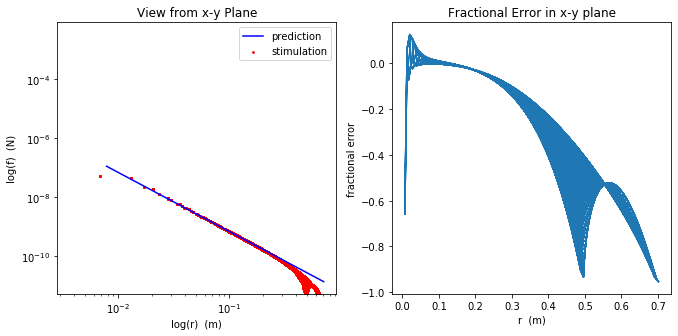

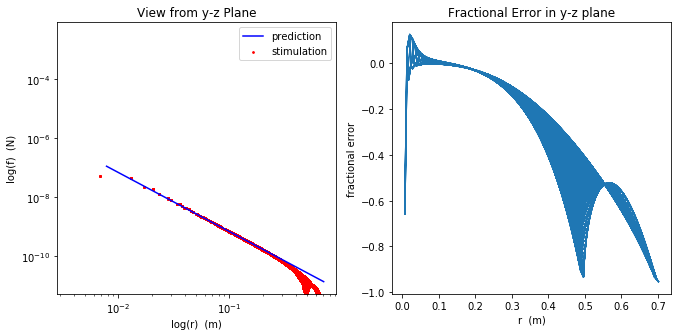

In [9]:
# prediction
def theoF(r):
    return G*m/r**2
x = np.linspace(L/Nc, sqrt(2)*L/2, 1000)
y = theoF(x)

# distance and absolute value of force in x-y plane
dis  = np.empty(Nc**2)
absf = np.empty(Nc**2)
n=0
for i in range(Nc):
    for j in range(Nc):
            dis[n]  = sqrt((i*l+l/2-L/2-e)**2+(j*l+l/2-L/2-e)**2+(Nc//2*l+l/2-L/2-e)**2)   # distance from center
            absf[n] = sqrt(fx[i,j,Nc//2]**2+fy[i,j,Nc//2]**2+fz[i,j,Nc//2]**2)             # magnitude of f
            n += 1
# plot xy
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(dis, absf, s = 3, c = 'r', alpha = 1, label = 'stimulation')
plt.plot(x,y, 'b' , label = 'prediction')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.title('View from x-y Plane')
plt.xlabel('log(r)  (m)')
plt.ylabel('log(f)  (N)')
plt.subplot(1,2,2)
theof = theoF(dis)
plt.plot(dis, (absf-theof)/theof)
plt.title('Fractional Error in x-y plane')
plt.xlabel('r  (m)')
plt.ylabel('fractional error')
plt.show()

# simulation in y-z
dis  = np.empty(Nc**2)
absf = np.empty(Nc**2)
n = 0
for j in range(Nc):
    for k in range(Nc):
            dis[n]  = sqrt((j*l+l/2-L/2)**2+(k*l+l/2-L/2)**2+(Nc//2*l+l/2-L/2-e)**2)   # distance from center
            absf[n] = sqrt(fx[Nc//2,j,k]**2+fy[Nc//2,j,k]**2+fz[Nc//2,j,k]**2) # magnitude of f
            n += 1
plt.figure(figsize=(11,5))
plt.subplot(1,2,1)
plt.scatter(dis, absf, s = 3, c = 'r', alpha = 1, label = 'stimulation')
plt.plot(x,y, 'b' , label = 'prediction')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc = 'upper right')
plt.title('View from y-z Plane')
plt.xlabel('log(r)  (m)')
plt.ylabel('log(f)  (N)')
plt.subplot(1,2,2)
theof = theoF(dis)
plt.plot(dis, (absf-theof)/theof)
plt.title('Fractional Error in y-z plane')
plt.xlabel('r  (m)')
plt.ylabel('fractional error')
plt.show()
plt.show()

Analysis of the erorr:

Overall a good fit, except for near the center and near the edge.

- Near the center:

The discreteness of the simulated space has an unavoidable spatial resolution limit, i.e., the cell size. Within the scale of grid size, finite differencing the potential cannot further the position difference smaller than one grid size. The error near the center is due to the small distance from the mass placed and the resolution limit.

- Near the edge:

Since Fourier Transform method uses periodic boundaries, when we solve the Poisson's equation, we are realling solving for an infinite space with periodic box, each with the same mass distribution. In this case, near the edge, the influenced of another particle over the periodic boundary is no longer negligible, the attraction of that virtual, periodically generated particle nearly cancels the attraction of the real one, resulting in a smaller value of force per unit mass than predicted.

## IV Interpolation of f

In [10]:
### Input:
# particle grid
# force per unit mass in 3 directions
### Output: 
# particle grid with acceleration updated

def toA(part, fx, fy, fz):
    # all positions
    x, y, z = part[:,0], part[:,1], part[:,2]
    # indices of the cell which directly contains the lower left corner of the cube that is occupied by a given particle
    i, j, k = floor(x/l), floor(y/l), floor(z/l)
    # periodic boundary condition
    i, j, k = mod(i, Nc), mod(j, Nc), mod(k, Nc)
    # position of that cell's center
    xc, yc, zc = i*l+l/2, j*l+l/2, k*l+l/2
    # two kinds of distance
    dx, dy, dz = abs(x-xc), abs(y-yc), abs(z-zc)
    ex, ey, ez = l-dx, l-dy, l-dz
    # the direction out of 8 possible directions the particle is point
    # represented by the relative position of the particle and the its cell's center
    # this determines which 8 cells out of 27 possible surrounding cells that the particle overlaps
    signx,signy,signz = sign(x-xc),sign(y-yc), sign(z-zc)
    # periodic boundary condition
    ip, jp, kp = mod(i+signx, Nc), mod(j+signy, Nc), mod(k+signz, Nc)
    # loop over all particles, each is influenced by its 8 overlaping cells
    for n in range(Np):
        a,b,c    = int(i[n]), int(j[n]), int(k[n])
        ap,bp,cp = int(ip[n]), int(jp[n]), int(kp[n])
        # 8 accelerations due to 8 cells
        ac0 = np.array([fx[a ,b ,c ], fy[a ,b ,c ], fz[a ,b ,c ]]) * ex[n]*ey[n]*ez[n]/l**3
        ac1 = np.array([fx[a ,bp,c ], fy[a ,bp,c ], fz[a ,bp,c ]]) * ex[n]*dy[n]*ez[n]/l**3
        ac2 = np.array([fx[a ,b ,cp], fy[a ,b ,cp], fz[a ,b ,cp]]) * ex[n]*ey[n]*dz[n]/l**3
        ac3 = np.array([fx[a ,bp,cp], fy[a ,bp,cp], fz[a ,bp,cp]]) * ex[n]*dy[n]*dz[n]/l**3
        ac4 = np.array([fx[ap,b ,c ], fy[ap,b ,c ], fz[ap,b ,c ]]) * dx[n]*ey[n]*ez[n]/l**3
        ac5 = np.array([fx[ap,bp,c ], fy[ap,bp,c ], fz[ap,bp,c ]]) * dx[n]*dy[n]*ez[n]/l**3
        ac6 = np.array([fx[ap,b ,cp], fy[ap,b ,cp], fz[ap,b ,cp]]) * dx[n]*ey[n]*dz[n]/l**3
        ac7 = np.array([fx[ap,bp,cp], fy[ap,bp,cp], fz[ap,bp,cp]]) * dx[n]*dy[n]*dz[n]/l**3
        part[n,(6,7,8)] = ac0+ac1+ac2+ac3+ac4+ac5+ac6+ac7
    return part

## V Time Development--Verlet Method

In [11]:
### Input:
# particle grid
### Output:
# current time step

def timestep(part):
    lam = 0.5 # factor for adaptive time step
    absa = sqrt(part[:,6]**2+part[:,7]**2+part[:,8]**2)
    absv = sqrt(part[:,3]**2+part[:,4]**2+part[:,5]**2)
    maxa = amax(absa)
    maxv = amax(absv)
    if maxv == 0 or maxa == 0:
        return 1
    else:
        dt = lam * min(l/maxv, sqrt(l/maxa))
        return dt

    
### Input:
# particle grid
# current time
### Output:
# particle grid after a single step of verlet method
# total simulated time

def doVerlet(part, currt):
    dt = timestep(part)
    vhalf = part[:,(3,4,5)] + part[:,(6,7,8)]*dt/2        # v(n+1/2) = v(n) + a(n) * dt/2
    part[:,(0,1,2)] = part[:,(0,1,2)] + vhalf*dt          # x(n+1)   = x(n) + vhalf * dt
    # calculate a(n+1), i.e., new acceleration due to x(n+1)
    rho = toRho(part)
    phi = Poisson_Solver(rho)
    fx, fy, fz = toF(phi)
    part = toA(part, fx, fy, fz) # update a(n) to a(n+1) 
    part[:,(3,4,5)] = vhalf + part[:,(6,7,8)]*dt/2         # v(n+1) = vhalf + a(n+1) * dt/2
    currt += dt
    return part, currt

## VI Multiple Verlet Steps and Graphing

### VI.I Graphing

In [12]:
# average density
def rhoavr(Rs):
    V = 4/3*pi*Rs**3
    return Ms/V
# dynamical time
def tdynam(Rs, rhos):
    return sqrt(3*pi/(16*G*rhos))


### Input:
# particle grid
# current time
### Plot particles in x-y and y-z plane

def graph(part,t):
    # extract position
    x, y, z = part[:,0],part[:,1],part[:,2]
    # graph
    plt.figure(figsize=(12,6))
    plt.subplot(1,2,1)
    # color code particle with its initial distance from center
    plt.scatter(x, y, s = 0.1, c=part[:,9]) 
    plt.title('x-y plot after '+str(np.round(t,3))+' dynamical time')
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)    
    plt.xlabel('x (m)')
    plt.ylabel('y (m)')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Initial r (m)', labelpad=-20, y=0.9)
    plt.subplot(1,2,2)
    plt.scatter(y, z, s = 0.1, c=part[:,9])
    plt.title('y-z plot after '+str(np.round(t,3))+' dynamical time')
    plt.axis('square')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel('y (m)')
    plt.ylabel('z (m)')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Initial r (m)', labelpad=-20, y=0.9)
    plt.show()

    
### Input: 
# particle grid
# distance
### Output: 
# mass enclosed within this distance

def enclosed(part, r):
    mass = 0
    for n in range(Np):
        if sqrt((part[n,0]-L/2)**2+(part[n,1]-L/2)**2+(part[n,2]-L/2)**2) < r:
            mass += m
    return mass


### Input: 
# particle grid
# radius of mass distribution
# current time
### graph current enclosed mass in comparison with it is initially
### Output: 
# an array of enclosed mass

initialmass = None
def graphEnclosedMass(part, Rs, t):
    r = np.linspace(0, L/2, 128, endpoint=True)
    mencl = np.zeros(128)
    i = 0
    for dis in r:
        mencl[i] = enclosed(part, dis)
        i += 1
    plt.figure(figsize = (9,6))
    plt.plot(r, mencl/Ms   ,'k', label = 'Current Enclosed Mass Profile')
    plt.plot(r, initialmass/Ms,'r', label = 'Initial Enclosed Mass Profile')
    plt.legend()
    plt.xlabel('Distance from Center (m)')
    plt.ylabel('Enclosed Mass Fraction')
    plt.title('Enclosed Mass Profile after '+str(np.round(t,3))+' dynamical time')
    plt.show()
    return mencl


### Input: 
# particle grid
# array of enclosed mass
# current time
### graph the acceleration value versus distance from center
### and compare to predicted value
### Output: 
# None

def graphAcceleration(part, mencl, t):
    r = sqrt((part[:,0]-L/2)**2+(part[:,1]-L/2)**2+(part[:,2]-L/2)**2)
    a = sqrt((part[:,6])**2+(part[:,7])**2+(part[:,8])**2)
    rpoints = np.linspace(l, L/2, 128, endpoint=True)
    theoa   = G * mencl/rpoints**2
    plt.figure(figsize = (9,6))
    plt.scatter(r, a, s=0.1, c=part[:,9], label = 'simulation')
    cbar = plt.colorbar(fraction=0.046, pad=0.04)
    cbar.set_label('Initial r (m)', labelpad=-20, y=0.9)
    plt.plot(rpoints,theoa,'k', label = 'prediction')
    upper = np.amax(a)
    plt.ylim(0, 1.1*upper)
    plt.legend(loc = 'upper right')
    plt.xlabel('radial distance from center (m)')
    plt.ylabel('acceleration (m/s^2)')
    plt.title('Acceleration Profile after '+str(np.round(t,3))+' dynamical time')
    plt.show()

    
# a wrapper, to make all graphs
def graphAll(part, Rs, t):
    graph(part,t)    
    mencl = graphEnclosedMass(part, Rs, t)
    graphAcceleration(part,mencl,t)

### VI.II The Simulate Function

We simulate for 1 dynamical time, and graph related information in about every 0.1 dynamical time. 

In [13]:
def simulate(part, Rs, rhos):
    tdyn = tdynam(Rs, rhos) # dynamical time
    currt = 0   # record current time
    # graph initial condition
    graph(part, currt) 
    graphEnclosedMass(part, Rs, currt/tdyn)
    # simulate and plot
    preplot = 0
    while currt/tdyn < 1:
        # verlet step, update particle grid and current time
        part, currt = doVerlet(part, currt)
        # graph at every 0.1tdyn
        thisplot = currt
        if (thisplot - preplot)/tdyn > 0.1: 
            graphAll(part, Rs, currt/tdyn)
            preplot = (thisplot//0.1)*0.1
            print("-------------------------------------------------------------------------------------------------")
    graphAll(part, Rs, currt/tdyn) # final snap

## VII Stimulation

### VII.I Initial Condition

Generate an array of particles, whose initial positions follow a uniform random distribution in a sphere of radius Rs.

In [14]:
# Fixing random state for reproducibility
Rs = L/4
Np = 32**3
Ms = Np*m
rhos = rhoavr(Rs)

# generate Np uniformly distributed points in a sphere with radius Rs
np.random.seed(2)
phi = random.rand(Np)*2*pi
cosine = random.rand(Np)*2-1
u = random.rand(Np)
theta = np.arccos(cosine)
r = Rs * u**(1/3)
x = r * sin(theta) * cos(phi) + L/2
y = r * sin(theta) * sin(phi) + L/2
z = r * cos(theta) + L/2

# initialize particle grid
part = np.zeros((Np, 10))
part[:,0], part[:,1], part[:,2] = x,y,z # set positions
# particles are color coded according to their initial distance from the center
colors = sqrt((x-L/2)**2+(y-L/2)**2+(z-L/2)**2)
part[:,9] = colors

# calculate initial mass profile
r = np.linspace(0, L/2, 128, endpoint=True)
initialmass = np.zeros(128)
i = 0
for dis in r:
    initialmass[i] = enclosed(part, dis)
    i += 1

## VII.II Stimulation

The function runs for about 10 minutes.

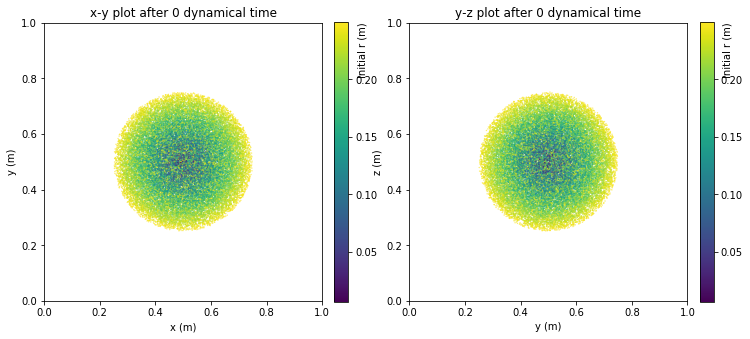

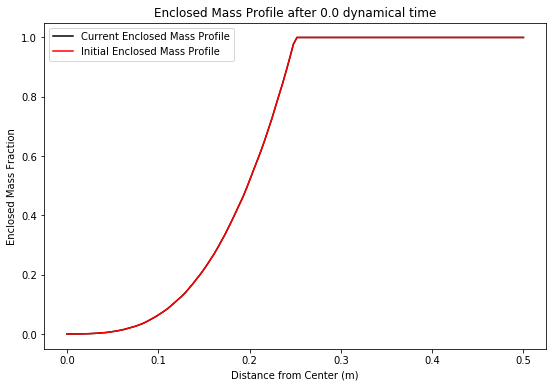

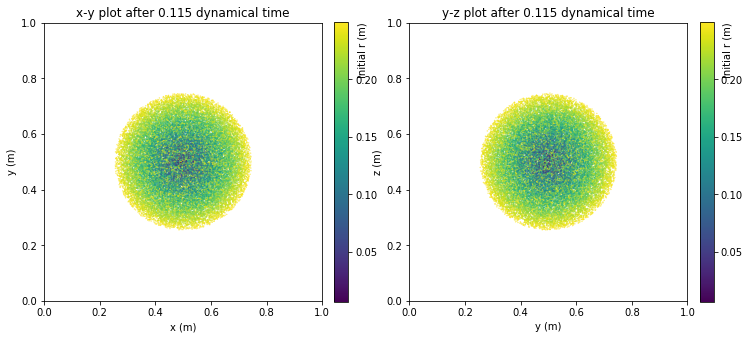

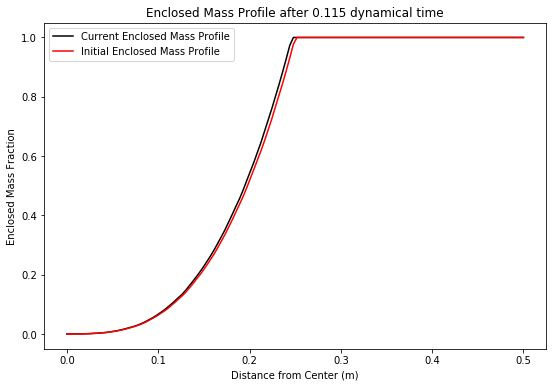

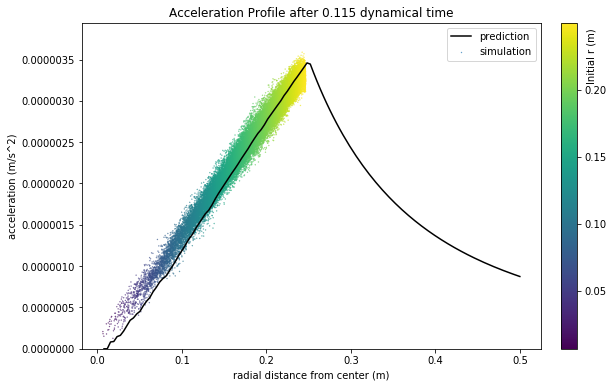

-------------------------------------------------------------------------------------------------


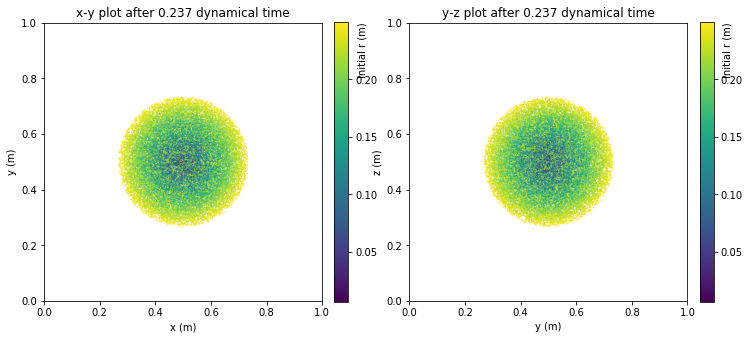

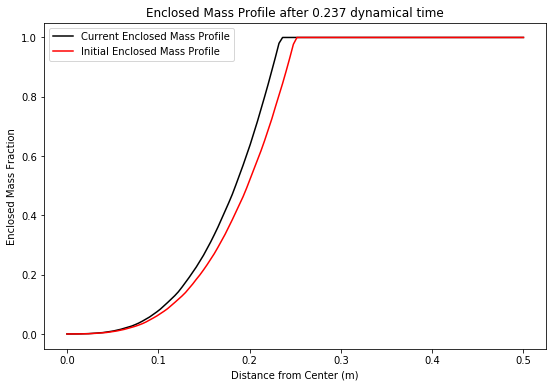

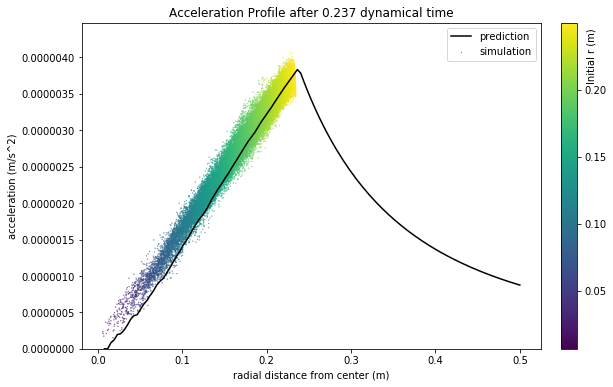

-------------------------------------------------------------------------------------------------


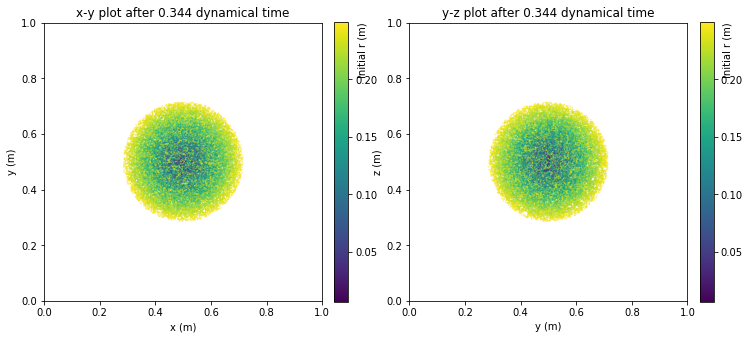

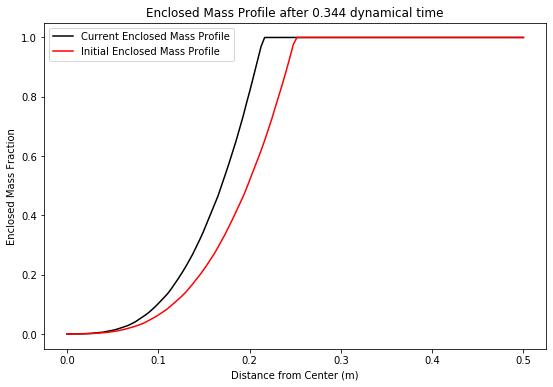

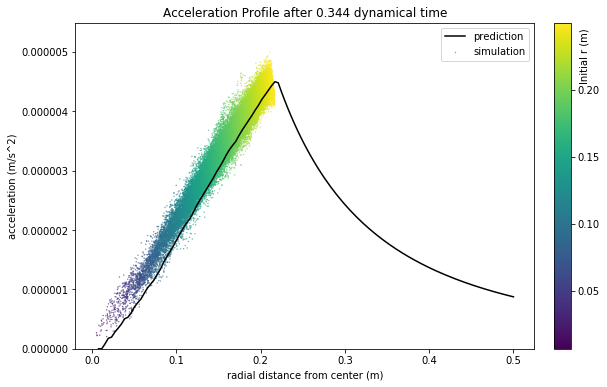

-------------------------------------------------------------------------------------------------


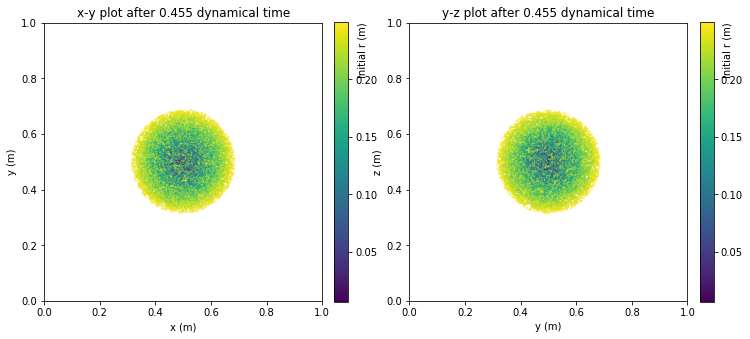

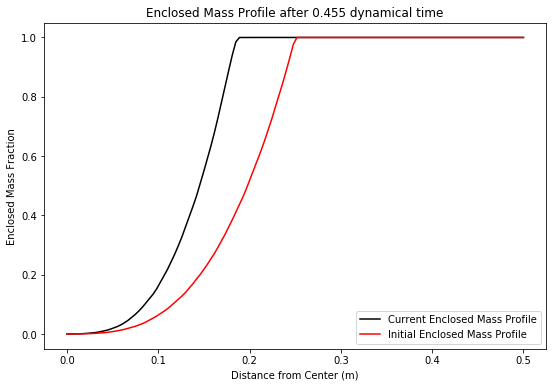

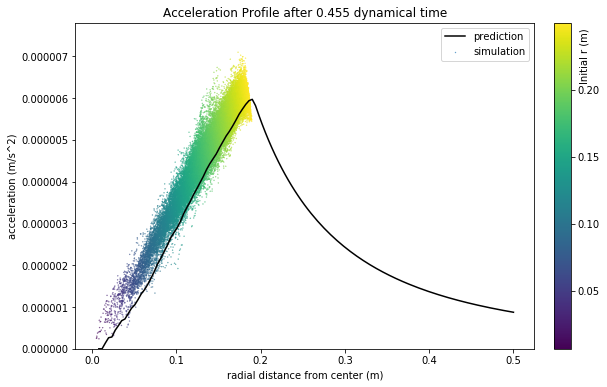

-------------------------------------------------------------------------------------------------


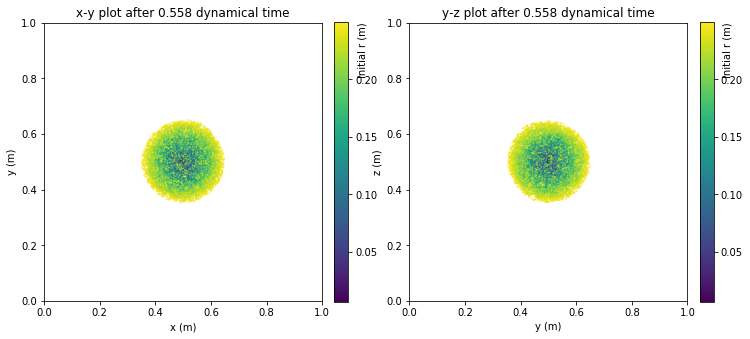

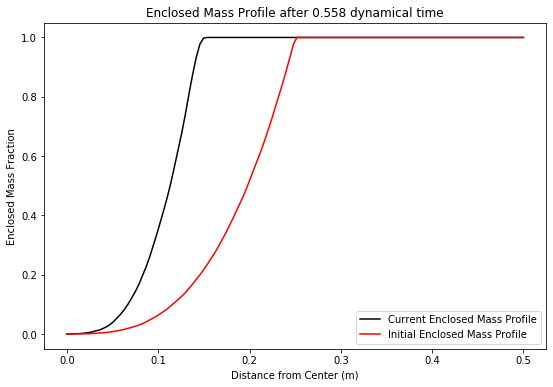

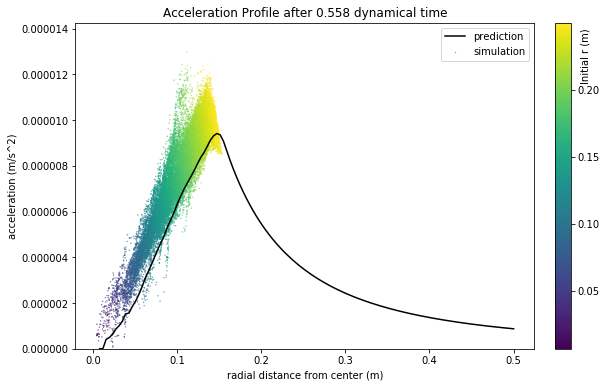

-------------------------------------------------------------------------------------------------


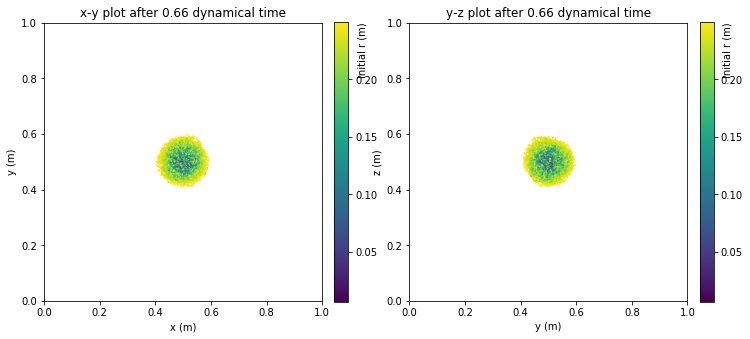

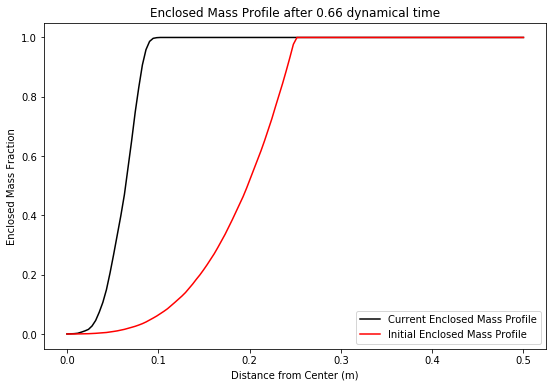

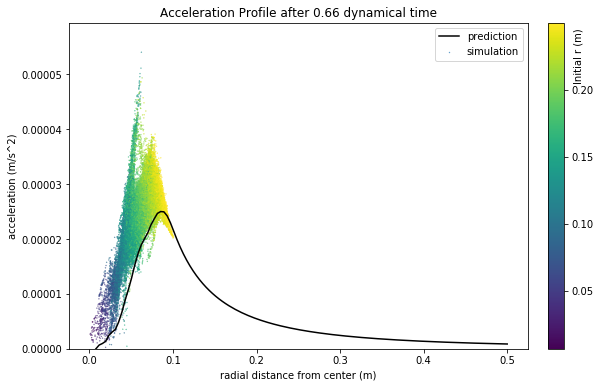

-------------------------------------------------------------------------------------------------


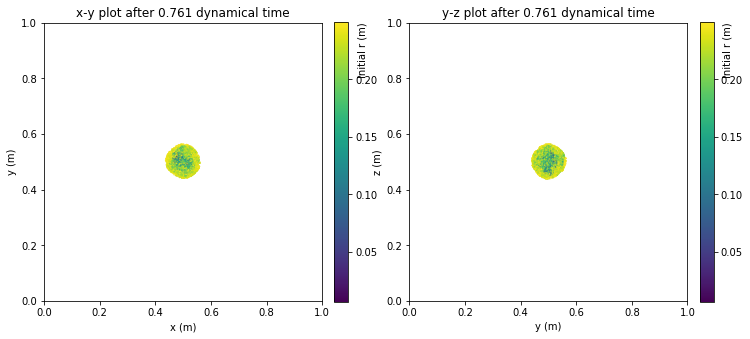

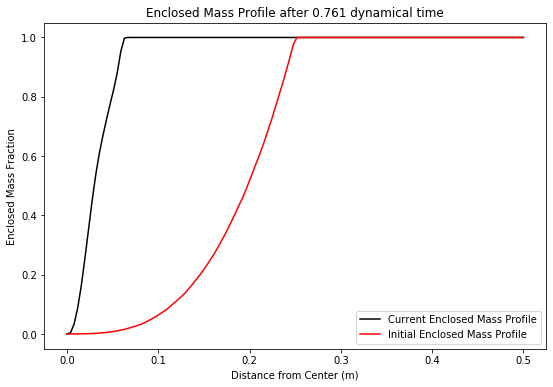

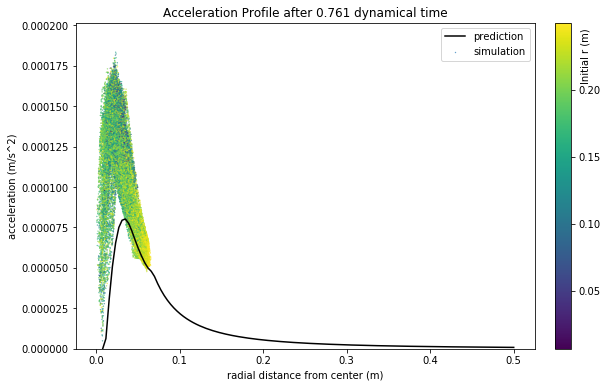

-------------------------------------------------------------------------------------------------


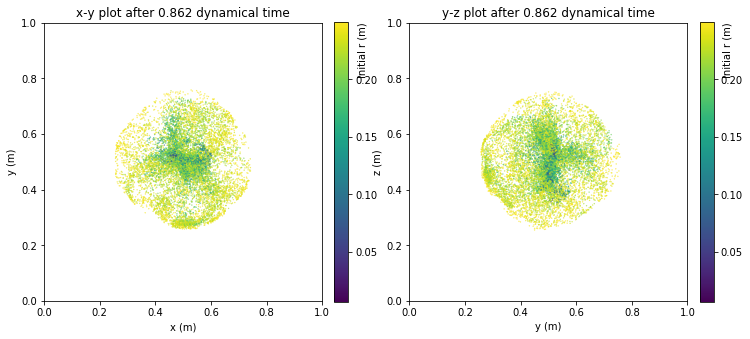

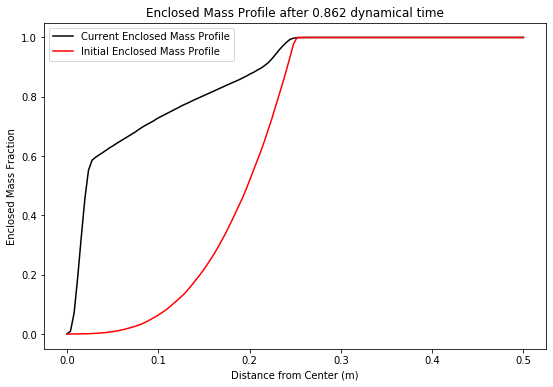

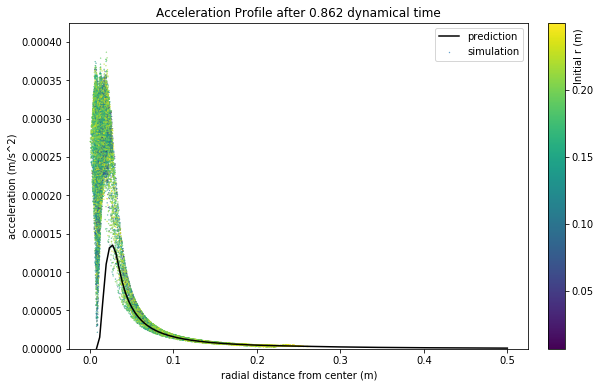

-------------------------------------------------------------------------------------------------


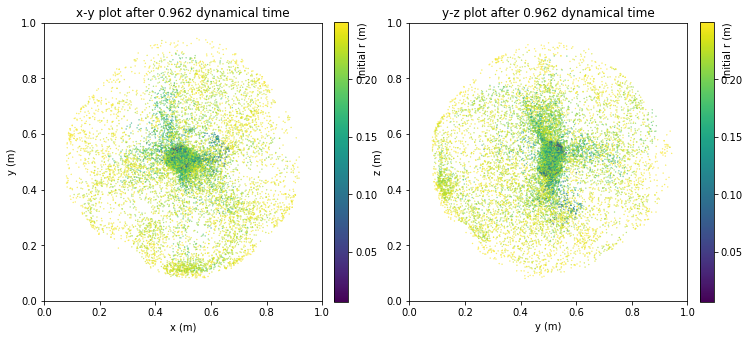

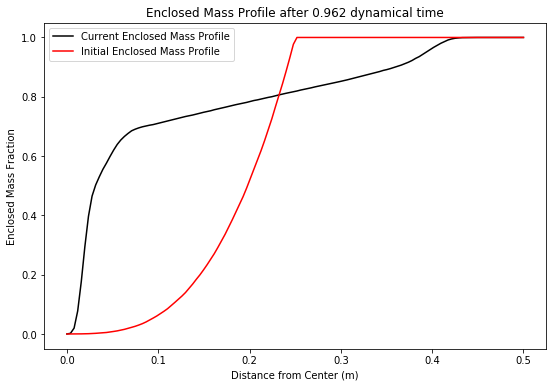

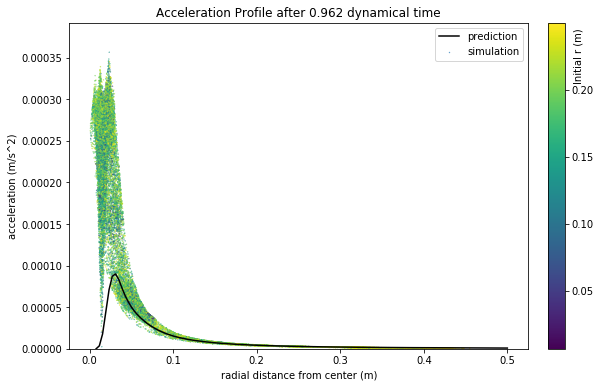

-------------------------------------------------------------------------------------------------


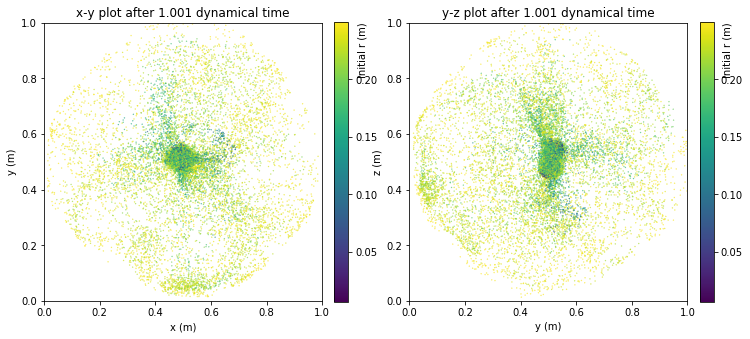

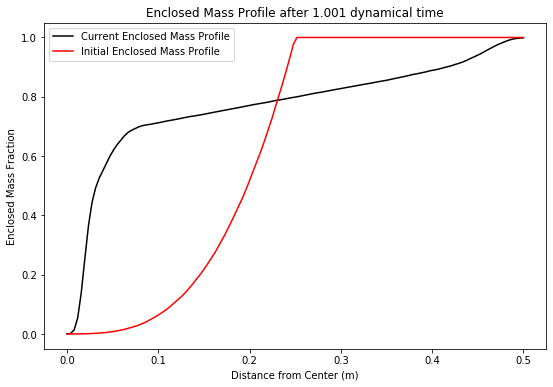

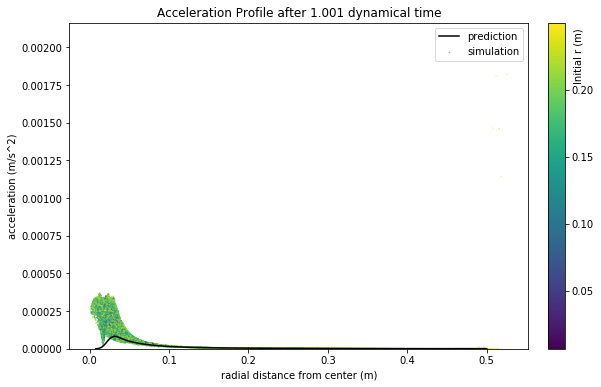

In [15]:
simulate(part, Rs, rhos)

## VIII Discussion

- About Contraction and Expansion

The simulation depicts a contraction of a mass distribution due to the influence of its own gravity. Its mass is drawn towards the center of the distribution. 

The dynamical time is the time it takes for a particle on the edge to fall to the center if at a perfectly homogeneous system. Simulation shows that the system collapses into a smallest radius at around 0.7~0.8 dynamical time. However, since PM method does not simulate collision, the collapsing particles pass through each other after reaching an overall smallest size. The initially less bounded particles (those initially on the edge) has the maximum speed when reaching the center, so they continue to travel away from the center; some of them might escape the system (in this case, nearly none has escaped the system yet within 1 dynamical time), others might collapse again. While a large portion of the mass has collapsed and stayed in a smaller region, there are a small amount of particles that become further from the center than the initial distribution's edge; the radius of the mass distribution finally becomes twice as it is initially, as shown in the final two snaps.

- About Acceleration

The acceleration at distance r from the center should be $a(r) = \frac{G M(<r)}{r^2}$, but we can observe the accleration near the center does not follow this pattern. This is again due to the resolution limit: near the center, the density of the particles is high, many of them are in one cell, and as mentioned earlier, the finite difference method does not resolute more than a cell size. Therefore, the force per unit mass and thus the acceleration deviates from theoretical prediction.

## IX Independent Work

## IX.I A New Initial Condition

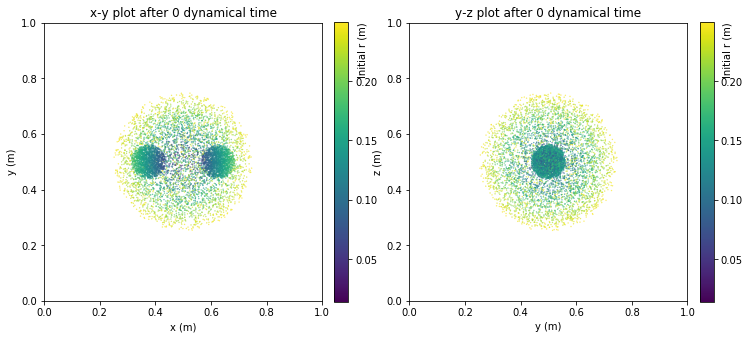

In [16]:
# Fixing random state for reproducibility
Rs = L/4
Np = 20**3
Nbig = 3*Np//5
Nsmall = Np//5
Ms = Np*m
rhos = rhoavr(Rs)

# generate Nbig uniformly distributed points in a big sphere at center with radius Rs/2
np.random.seed(2)
phibig = random.rand(Nbig)*2*pi
cosinebig = random.rand(Nbig)*2-1
ubig = random.rand(Nbig)
thetabig = np.arccos(cosinebig)
rbig = Rs * ubig**(1/3)
xbig = rbig * sin(thetabig) * cos(phibig) + L/2
ybig = rbig * sin(thetabig) * sin(phibig) + L/2
zbig = rbig * cos(thetabig) + L/2

# generate Nsmall uniformly distributed points in a large disk
# centered at the side of the sphere with radius Rs/8
np.random.seed(10)
phismall = random.rand(Nsmall)*2*pi
cosinesmall = random.rand(Nsmall)*2-1
usmall = random.rand(Nsmall)
thetasmall = np.arccos(cosinesmall)
rsmall1 = Rs/4 * usmall**(1/3)
xsmall1 = rsmall1 * sin(thetasmall) * cos(phismall) + L/2+Rs/2
ysmall1 = rsmall1 * sin(thetasmall) * sin(phismall) + L/2
zsmall1 = rsmall1 * cos(thetasmall) + L/2

np.random.seed(11)
phismall = random.rand(Nsmall)*2*pi
cosinesmall = random.rand(Nsmall)*2-1
usmall = random.rand(Nsmall)
thetasmall = np.arccos(cosinesmall)
rsmall2 = Rs/4 * usmall**(1/3)
xsmall2 = rsmall2 * sin(thetasmall) * cos(phismall) + L/2-Rs/2
ysmall2 = rsmall2 * sin(thetasmall) * sin(phismall) + L/2
zsmall2 = rsmall2 * cos(thetasmall) + L/2


# concatenate all particles' position
x = np.concatenate((xbig,xsmall1,xsmall2))
y = np.concatenate((ybig,ysmall1,ysmall2))
z = np.concatenate((zbig,zsmall1,zsmall2))


# initialize particle grid
part = np.zeros((Np, 10))
part[:,0], part[:,1], part[:,2] = x,y,z
colors = sqrt((x-L/2)**2+(y-L/2)**2+(z-L/2)**2)
part[:,9] = colors

graph(part,0)
r = np.linspace(0, L/2, 128, endpoint=True)
initialmass = np.zeros(128)
i = 0
for dis in r:
    initialmass[i] = enclosed(part, dis)
    i += 1

Two more compacted sphere, with radius $\frac{Rs}{4}$ and together having $\frac{2}{5}$ of the total mass, are placed in the plane $z = \frac{L}{2}$ symmetrically about the $y$ axis. The total number of particles is reduced to $20^3$ instead of $32^3$ for higher accuracy (due to lower density) and shorter runtime.

### IX.II Simulation

The code runs for about 5 minutes.

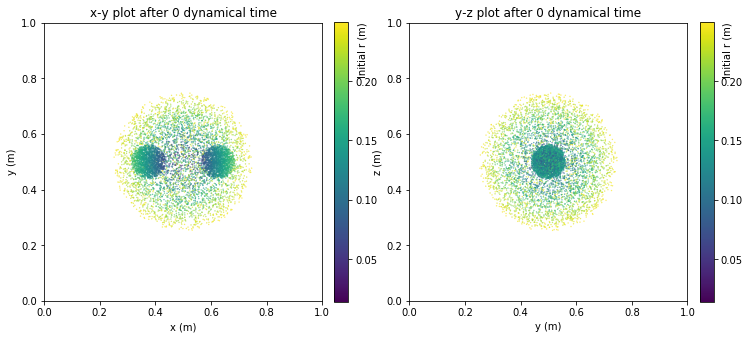

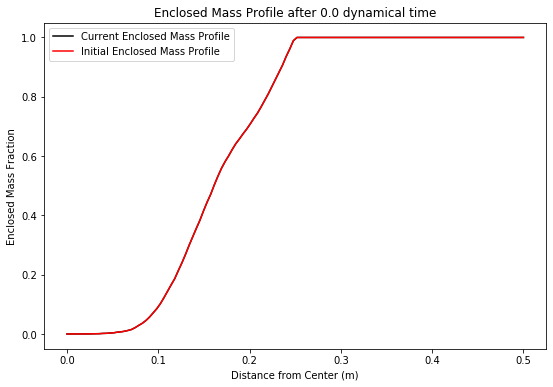

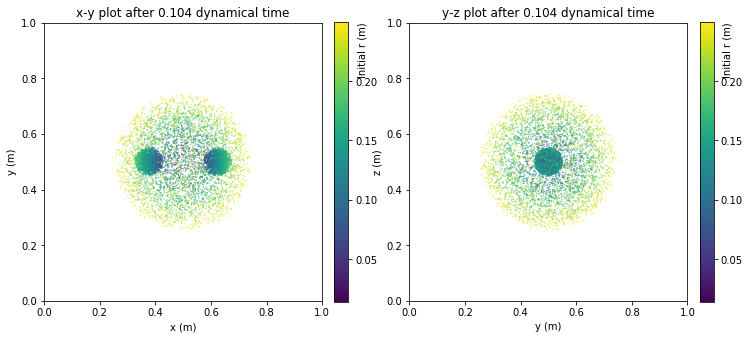

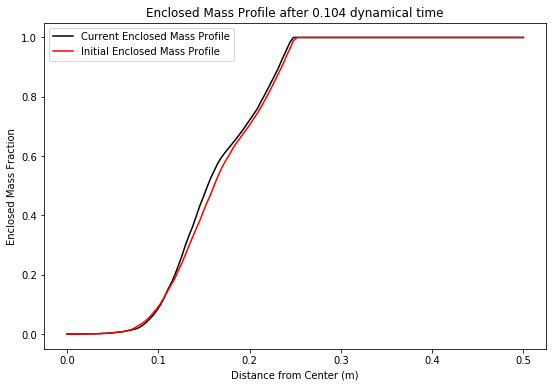

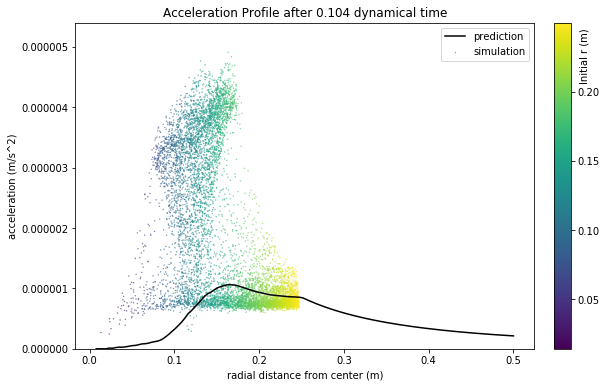

-------------------------------------------------------------------------------------------------


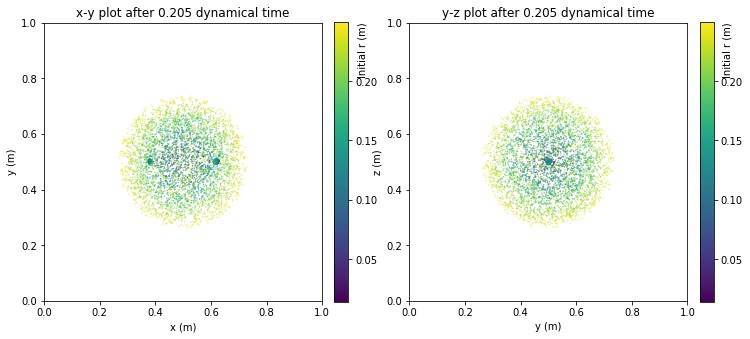

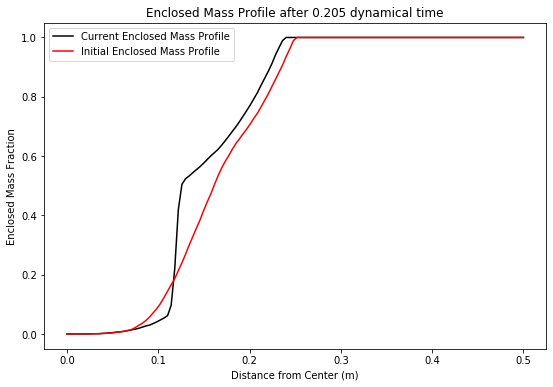

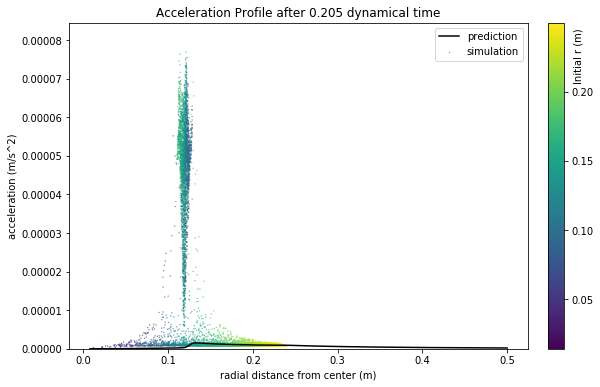

-------------------------------------------------------------------------------------------------


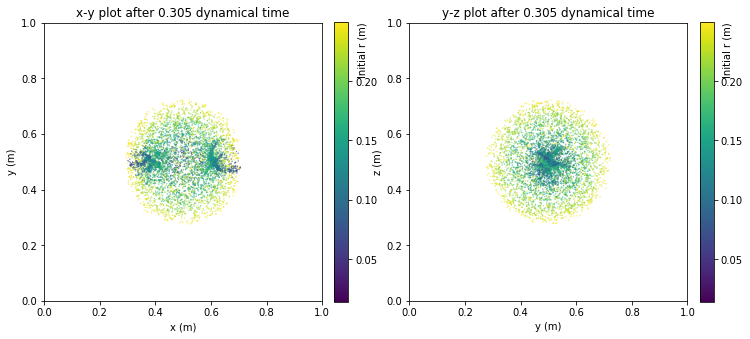

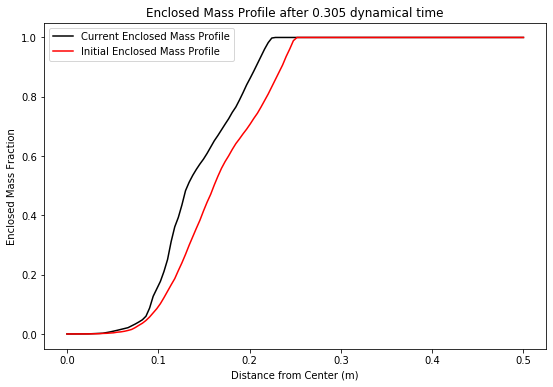

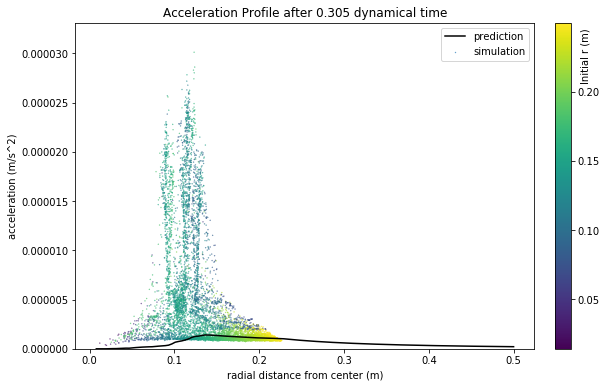

-------------------------------------------------------------------------------------------------


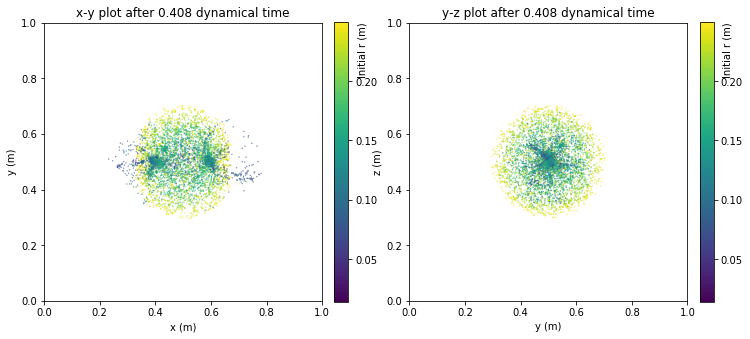

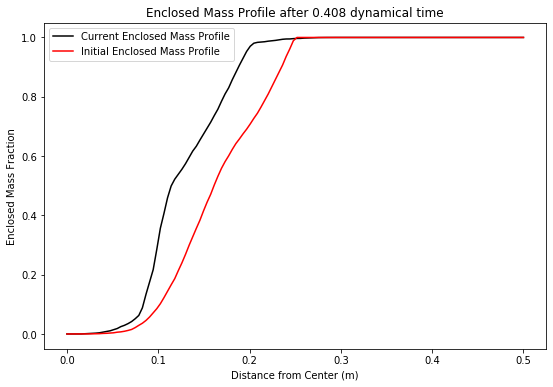

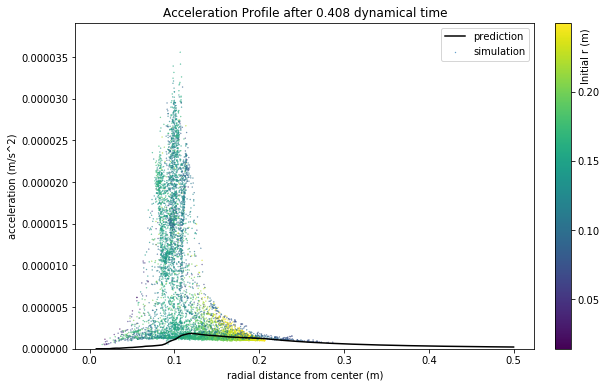

-------------------------------------------------------------------------------------------------


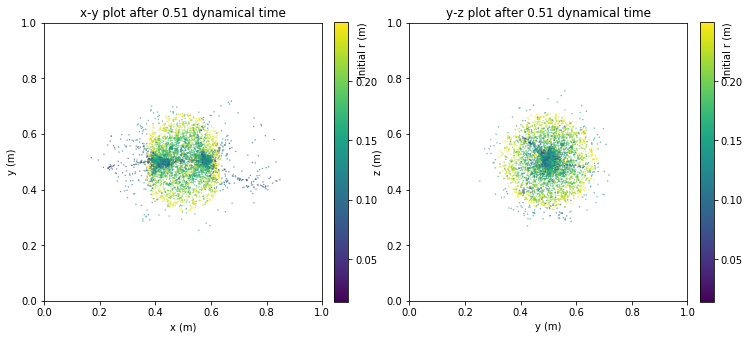

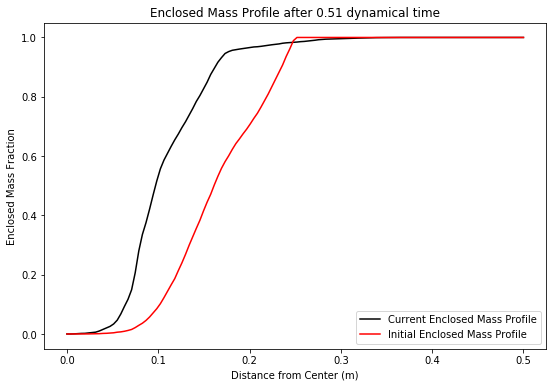

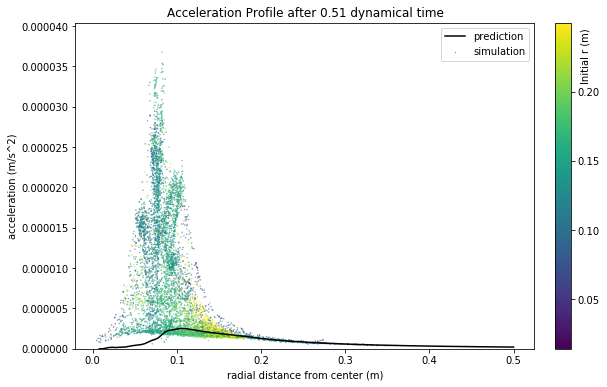

-------------------------------------------------------------------------------------------------


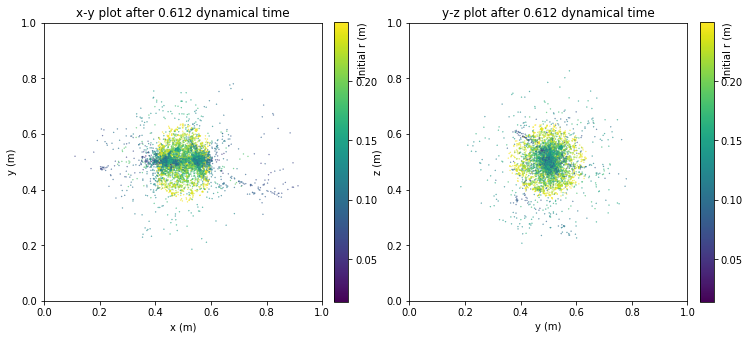

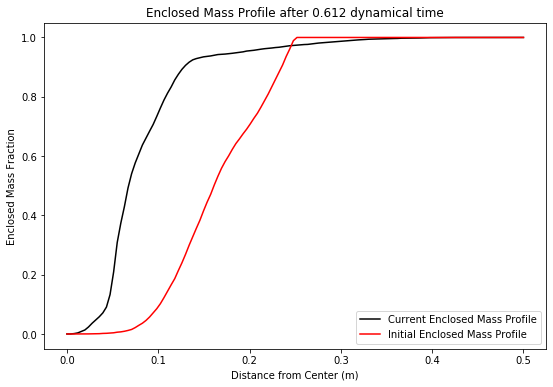

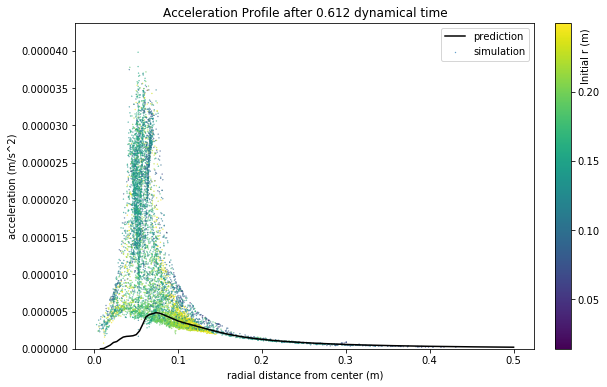

-------------------------------------------------------------------------------------------------


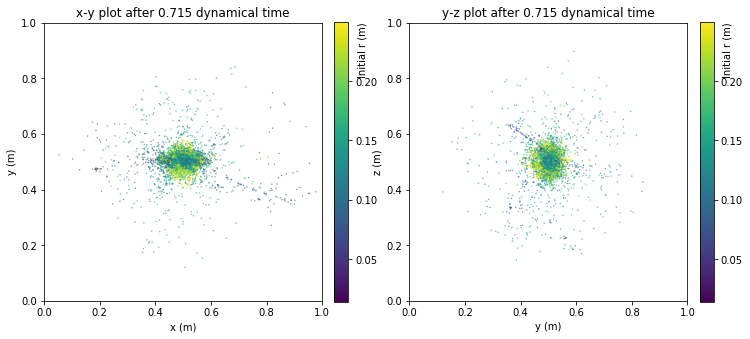

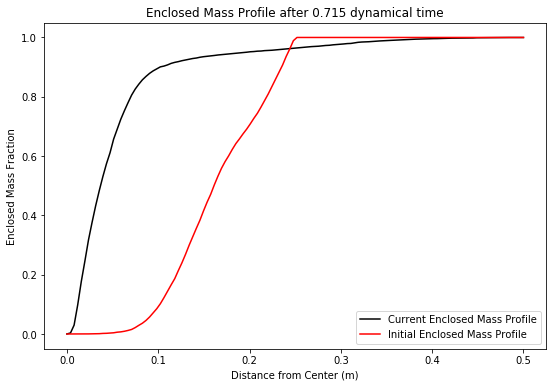

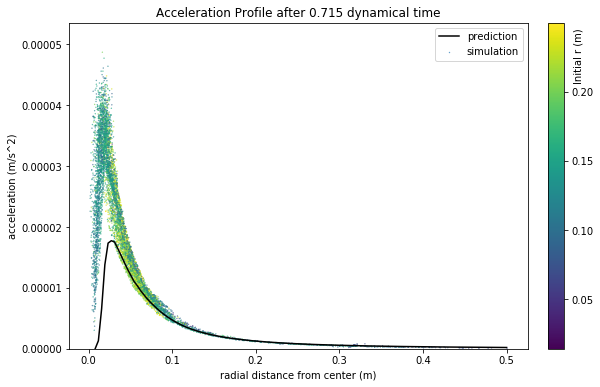

-------------------------------------------------------------------------------------------------


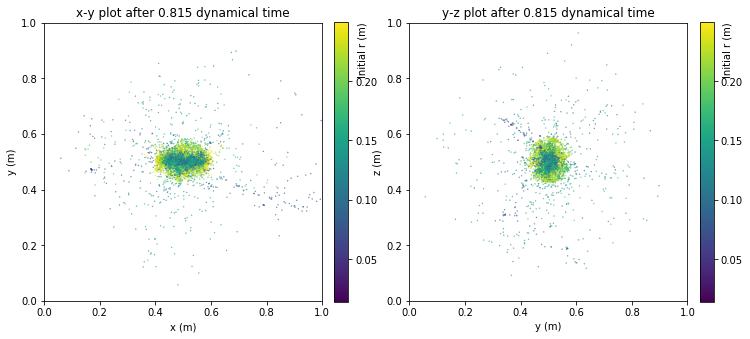

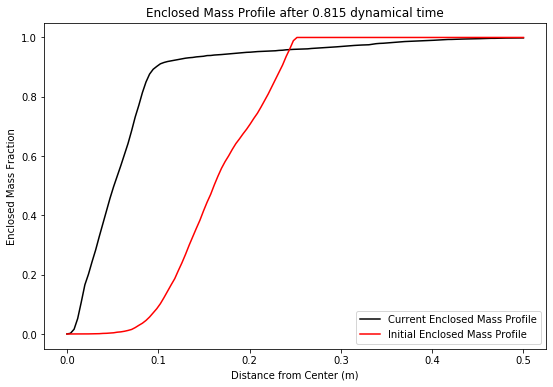

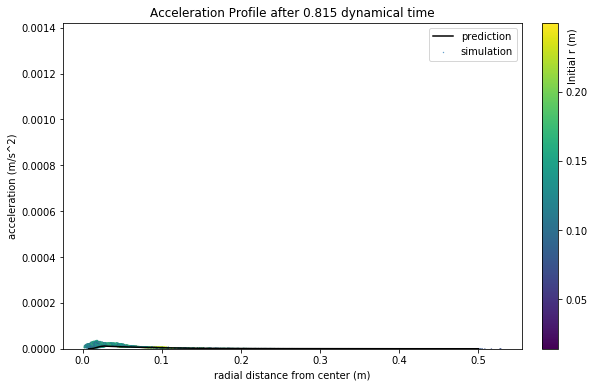

-------------------------------------------------------------------------------------------------


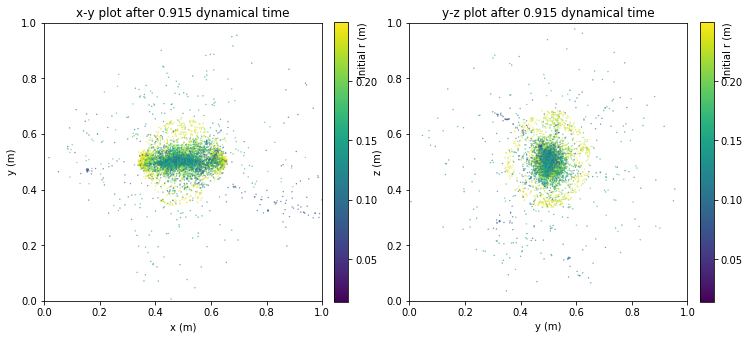

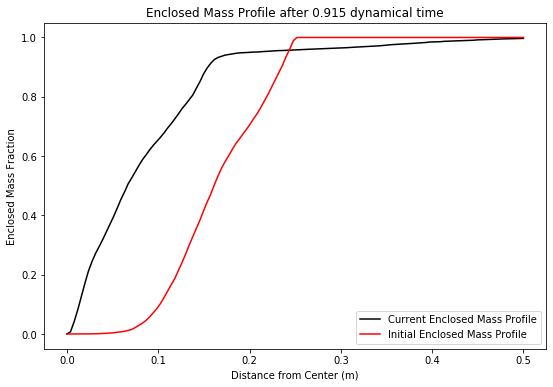

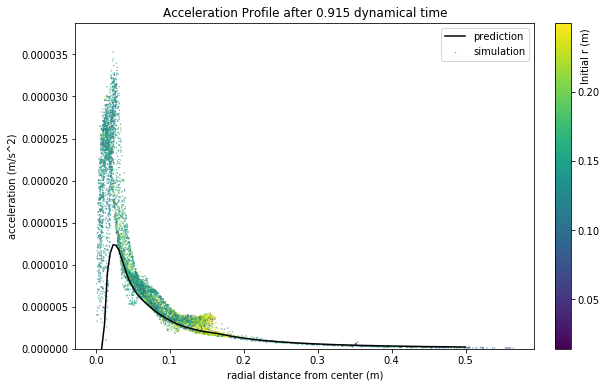

-------------------------------------------------------------------------------------------------


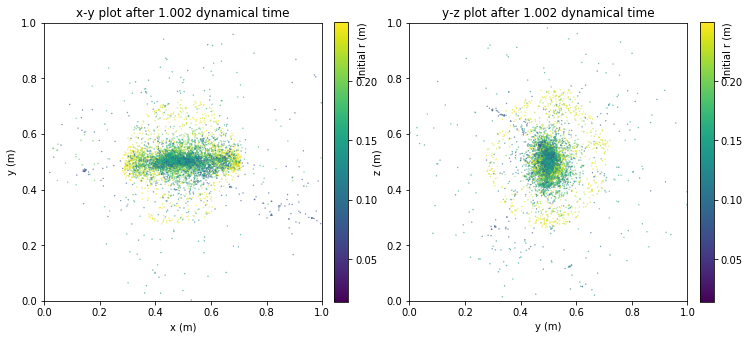

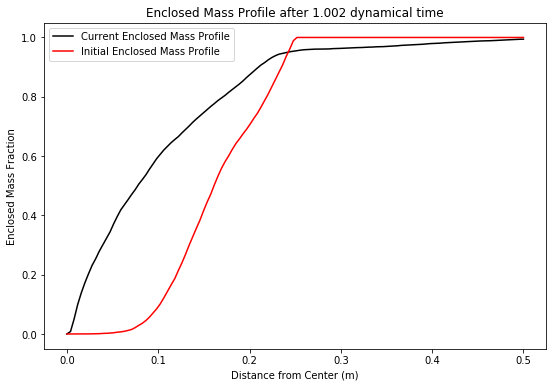

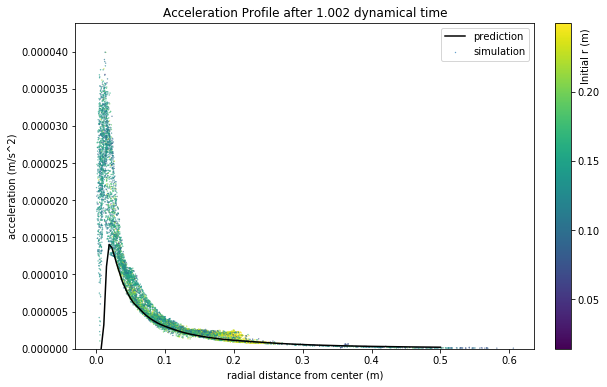

In [17]:
simulate(part, Rs, rhos)

## X Discussion

- $ 0-0.2$ dynamical time

Locally, the two compacted regions collapse towards their respective center; this local collapse, however, does not always happen -- I tried another ratio of the compacted region and they attract each other first instead of collapse locally. The gravitational bound of these two region themselves must temporarily dominate the attraction of one towards another for the two centers of the compacted region not to move towards the global center.

- $ 0.3-0.4$ dynamical time 

The two collapsed region propably reached their own "dynamical time" and start to diffuse away from their centers due to the collisionless nature of the simulation (same mechanism of the diffusion happend in the previous simulation after ~$0.7$ dynamical time). Their centers have not yet moved much. The surrounding less dense particles start to be attracted to the center by a little.

- $ 0.5-0.6$ dynamical time

The two compacted regions are now moving towards each other. And, particles on the left and right edge of the whole distribution (along x direction) collapse more than those along y direction due to that the two compacted, dominating regions are along x direction. Therefore, the overall size of the mass distribution started to become a little ellipsoidal. A few particles with high velosity diffuse (nearly isotropically) through previously unoccupied space.

- $ 0.7 $ dynamical time

At around $ 0.7-0.8$ dynamical time, the same time when the distribution collapses into its smallest size in the previous simulation,  this distribution also collapses into its smallest size. The difference is that this one contains slightly less bounded particles floating around at large distance from the center.

- $ 0.8 $ dynamical time

The two compacted region of particles now pass through each other, enlarging the size of the distribution. The overall shape is stil ellipsoidal, but the semi-major axis is now along $x$ direction. 

- $ 0.9-1 $ dynamical time

The eccentricity of the distribution continues to increase, gradually forming a horizontal "bar" when viewd in x-y plane. y-z plane appears similar to the previous simulation before 0.9 dynamical time, but from 0.9 dynamical time, a ring-like sub-distribution forms, centered at the center. This might be the pass-through-and-diffuse pattern again, as we can see in the final plot that the ring grows larger while most mass is bounded tightly to the center.

- About Acceleration

Acceleration plots again confirm the hypothesis that the deviation from theoretically calculated acceleration is due to the resolution limit and high density--the maximum deviation occurs at where the maximum densities are (e.g., maximum deviation occurs at ~$ 0.8 m$ in $ 0.5$ dynamical time plot).